# Statisztika Házi Feladat
## Jankó András - NHVU6N

## 1. Feladat
### Hipotézisvizsgálat

Először beolvassuk az mintánkat:

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use('dark_background')


In [50]:
def custom_stats(data):
    print("------------------------HEAD------------------------")
    print(data.head())
    print("------------------------SHAPE------------------------")
    print(data.shape)
    print("------------------------Stats------------------------")
    print(data.describe())

# remove quotes and split by comma
def process_row(row):
    return [float(x) for x in row.strip('"').split(',')]

with open('bead1.csv', 'r') as file:
    # skip first row
    lines = file.readlines()[1:]
    data_list = [process_row(line.strip()) for line in lines]


In [51]:
data = pd.DataFrame(data_list, columns=['Tabby', 'Black', 'White', 'Spotted', 'Red'])
custom_stats(data)


------------------------HEAD------------------------
   Tabby  Black  White  Spotted   Red
0   3.61   4.26   5.97     3.11  5.41
1   6.88   4.66   7.71     4.60  6.93
2   8.68   6.62   6.79     5.51  4.02
3   7.05   6.42   5.26     5.57  6.26
4   3.22   5.47   5.47     4.82  4.70
------------------------SHAPE------------------------
(50, 5)
------------------------Stats------------------------
           Tabby      Black      White    Spotted        Red
count  50.000000  50.000000  50.000000  50.000000  50.000000
mean    5.468000   5.548400   5.773000   5.427000   5.403400
std     1.620715   1.161314   1.476867   1.605811   1.594156
min     0.640000   3.330000   2.310000   2.400000   2.050000
25%     4.487500   4.652500   4.650000   4.060000   4.235000
50%     5.560000   5.505000   5.690000   5.540000   5.260000
75%     6.617500   6.435000   6.805000   6.522500   6.347500
max     8.700000   8.640000   8.780000   8.590000  10.000000


### Teszt típusának kiválasztása

Egy darab független változónk van, és minden cica egyszer lett megmérve. Átlagokat szeretnénk összehasonlítani csoportok között.

-> Tehát egyszempontos varianciaanalízist alkalmazunk (One-Way ANOVA)

H₀​: μ1 ​= μ2 ​= μ3 ​= μ4 ​= μ5 Tehát nincs különbség a különböző kismacskák szundikálási szokásai között.

H₁: μi ​!= μj Legalább egy csoportnak eltérő szundikálási szokásai vannak.

Mindezt α = 0.05 szignifikanciaszinten.

### Érdekességként benthagyom, ezt a gondolathálót használtam a teszt eldöntésére:
How many IVs?

─ One → Are measurements repeated?

   ── Yes → Repeated Measures ANOVA

   ── No → One-way ANOVA

─ Two → Are measurements repeated?

   ── Yes → Mixed ANOVA

   ── No → Two-way ANOVA

─ Are there covariates?

   ── Yes → ANCOVA

How many DVs?

─ Multiple → MANOVA

In [52]:
melted_data = data.melt(var_name='Fur_Color', value_name='Nap_Duration')
custom_stats(melted_data)


------------------------HEAD------------------------
  Fur_Color  Nap_Duration
0     Tabby          3.61
1     Tabby          6.88
2     Tabby          8.68
3     Tabby          7.05
4     Tabby          3.22
------------------------SHAPE------------------------
(250, 2)
------------------------Stats------------------------
       Nap_Duration
count    250.000000
mean       5.523960
std        1.495685
min        0.640000
25%        4.442500
50%        5.500000
75%        6.515000
max       10.000000


### Feltételek ellenőrzése

Az egyszempontos ANOVA alkalmazhatóságához szükséges az adat normál eloszlása, és hogy a csoportok szórásai azonosak legyenek. Én jelenleg 3 olyan próbát ismerek amelyek alkalmasak a csoport szórások egyenlőségének eldöntésére.
1. Bartlett - Akkor jó amikor tudjuk hogy a populáció normális eloszlású. Ha nem az akkor pontatlan eredményt adhat.
2. Levene - Általánosabb teszt, ami kevésbé érzékeny ha az adat nem normális eloszlást követ.
3. Box M - Multivariate ANOVA-nál szokták használni.

A minta normális eloszlásának teszteléséhez Shapiro-Wilk tesztet használjunk.
Mivel a feladat szövege nem tér ki rá hogy az a teljes populáció normális eloszlásból származna, ezért legyünk konzervatívak és használjunk Levene tesztet.

#### Shapiro-Wilk próba

H₀: A minta normális eloszlást követ.

H₁: A minta nem normális eloszlást követ.


Tabby:
Shapiro-Wilk test p-value: 0.8253

Black:
Shapiro-Wilk test p-value: 0.7871

White:
Shapiro-Wilk test p-value: 0.7673

Spotted:
Shapiro-Wilk test p-value: 0.4380

Red:
Shapiro-Wilk test p-value: 0.3600


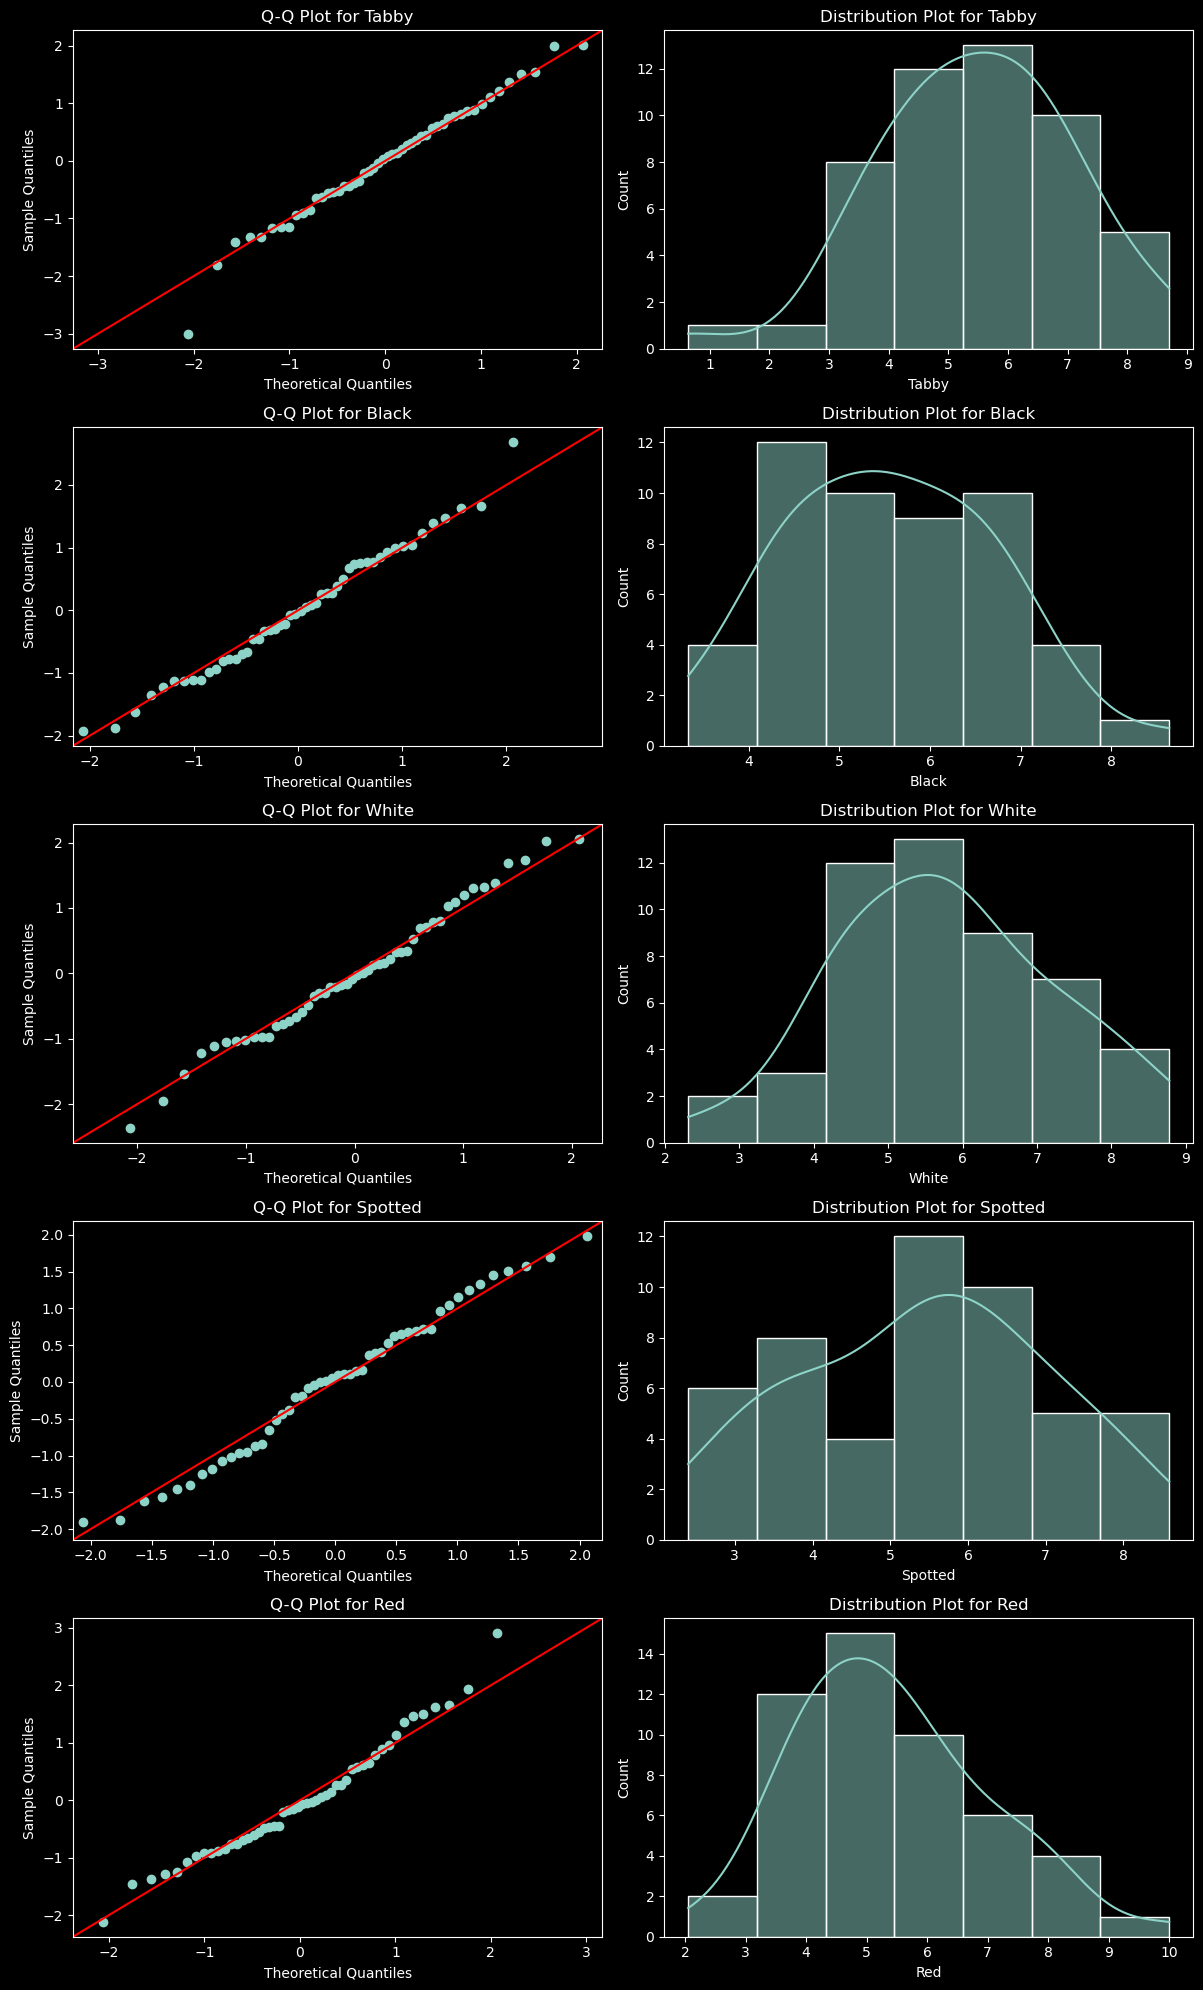

In [53]:
def create_qq_plot(data, color, ax):
    sm.qqplot(data, fit=True, line='45', ax=ax)
    ax.set_title(f'Q-Q Plot for {color}')

def create_dist_plot(data, color, ax):
    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(f'Distribution Plot for {color}')

def test_normality(data, group_name):
    print(f"\n{group_name}:")
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f"Shapiro-Wilk test p-value: {shapiro_p:.4f}")

fur_colors = ['Tabby', 'Black', 'White', 'Spotted', 'Red']
fig, axes = plt.subplots(len(fur_colors), 2, figsize=(12, 4*len(fur_colors)))
plt.subplots_adjust(hspace=0.4)

for i, color in enumerate(fur_colors):
    test_normality(data[color], color)
    create_qq_plot(data[color], color, axes[i, 0])
    create_dist_plot(data[color], color, axes[i, 1])

plt.tight_layout()
plt.show()

Mindegyik p érték nagyobb α = 0.05-nél így nem tudjuk elutasítani, hogy a mintánk normális eloszlást követ.

Mivel:

A p-érték annak a valószínűsége, hogy megkapjuk a megfigyelt (vagy még szélsőségesebb) adatainkat, HA a nullhipotézis igaz

Ha az adatok valóban normális eloszlásúak (H₀ igaz):

Magas p-értékeket várunk (mint amiket kaptunk) -> p > 0,05 azt jelenti, hogy "ezek az adatok meglehetősen összhangban vannak a normalitással"

Ha az adatok nem normális eloszlásúak (H₁ igaz):

Alacsony p-értékeket várunk -> p ≤ 0,05 azt jelentené, hogy "ezek az adatok valószínűtlenek normális eloszlás esetén"

### A fenti diagramokról is jól látható hogy nagyjából normál eloszlást követnek a minták.

Most rátérhetünk a csoportszórások azonosságának vizsgálatára.

$H_{0}$: A csoportok szórása azonos az adott szignifikanciaszint mellett.

$H_{1}$: Van legalább egy csoport, amelynek nem azonos a szórása. 

In [54]:
# Levene's test for homogeneity of variances
stat, p_value = stats.levene(*[data[color] for color in fur_colors])
print(f"\nLevene's test p-value: {p_value:.4f}")



Levene's test p-value: 0.2756


p = 0.2756 > 0.05 (α) -> Így nem utasítjuk el $H_{0}$-át

### Mivel Xi ~ N(μi, σi²) és σ₁² = σ₂² = σ₃² = σ₄² = σ₅² ezért használhatjuk az egyszempontú ANOVA-t.

ahol mégegyszer:

#### $H_{0}$: μ₁ = μ₂ = μ₃ = μ₄ = μ₅

#### $H_{1}$: ∃ i,j: μᵢ ≠ μⱼ

In [55]:
f_stat, p_value = stats.f_oneway(*[data[color] for color in fur_colors])
print(f"\nANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")



ANOVA results:
F-statistic: 0.4971
p-value: 0.7379


Ahol F = MSB/MSW

MSB = ∑nᵢ(x̄ᵢ - x̄)²/(k-1)

MSW = ∑∑(xᵢⱼ - x̄ᵢ)²/(N-k)

Mivel p = 0.7379 > 0.05 α, így nem utasítjuk el a nullhipotézist.

Ezen a ponton nem kellene tovább mennünk, felesleges post-hoc tesztet is végezni de kíváncsiságból megcsináltam, és benne is hagytam a feladatban mert úgy gondolom így méginkább látszik hogy statisztikailag nincs különbség az egyes csoportok között.

### Tehát mégegyszer ezen a ponton kijelentem hogy a fenti szignifikanciaszint mellett nincs bizonyíték arra hogy statisztikailag különbség lenne a különböző szőrű macskák szundikálási szokásai között.

In [56]:
tukey = pairwise_tukeyhsd(melted_data['Nap_Duration'],
                         melted_data['Fur_Color'])
print("\nTukey's HSD results:")
print(tukey)



Tukey's HSD results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  Black     Red   -0.145 0.9889 -0.9704 0.6804  False
  Black Spotted  -0.1214 0.9944 -0.9468  0.704  False
  Black   Tabby  -0.0804 0.9989 -0.9058  0.745  False
  Black   White   0.2246 0.9449 -0.6008   1.05  False
    Red Spotted   0.0236    1.0 -0.8018  0.849  False
    Red   Tabby   0.0646 0.9995 -0.7608   0.89  False
    Red   White   0.3696 0.7335 -0.4558  1.195  False
Spotted   Tabby    0.041 0.9999 -0.7844 0.8664  False
Spotted   White    0.346 0.7785 -0.4794 1.1714  False
  Tabby   White    0.305 0.8481 -0.5204 1.1304  False
-----------------------------------------------------


Az utolsó reject oszlopban láthatjuk hogy elutasítjuk-e a nullhipotézist ami soronként a group1 és group2 közötti különbséget jelenti, és mivel semelyik sorban nem tudjuk elutasítani, így ebből a tesztből is arra következtetünk hogy nem vethetjük el a nullhipotézist.

-----------------------------------------------------------------------------------------------------

# 2. Feladat
## Lineáris Regresszió

Először beolvassuk az mintánkat:

In [57]:
with open('bead2.csv', 'r') as file:
    lines = file.readlines()[1:]
    data_list = [process_row(line.strip()) for line in lines]

df = pd.DataFrame(data_list, columns=['Y','X1','X2'])
custom_stats(df)


------------------------HEAD------------------------
      Y    X1    X2
0  10.0  5.81  0.99
1  10.0  6.32  2.43
2   0.0  0.13  7.22
3   2.8  6.64  8.56
4   0.0  1.78  8.30
------------------------SHAPE------------------------
(50, 3)
------------------------Stats------------------------
               Y         X1         X2
count  50.000000  50.000000  50.000000
mean    4.394800   4.186400   4.700600
std     4.214424   2.910014   2.962346
min     0.000000   0.130000   0.130000
25%     0.000000   1.782500   2.467500
50%     3.160000   4.120000   4.230000
75%     9.732500   6.507500   7.535000
max    10.000000   9.970000   9.840000


Ahol Y a dorombolási idő hossza percben, X1 a szundikálási idő órában, és X2 a napi elfogyasztott tej mennyisége.

# 2.1 Becslések

## 2.1.1 Együtthatók pontbecslése és standardizált együtthatók

Alap egyenlet: Y = β₀ + β₁X₁ + β₂X₂ + ε

β₀, β₁, β₂ -> ezek az együtthatók

ε pedig a hibatag

A (β̂₀, β̂₁, β̂₂) együtthatók mondják meg hogy egy teoritikus előrejelzéshez milyen értékeket kell társítani az alapegyenletben. A következőképpen kaphatjuk meg őket:

$\hat{\beta} = (X'X)^{-1}X'Y$ -> ezt a mátrixos alakú egyenletet megoldjuk vagy ezt az egyenletrendszert:

$\sum Y = n\hat{\beta}_0 + \hat{\beta}_1 \sum X_1 + \hat{\beta}_2 \sum X_2$

$\sum YX_1 = \hat{\beta}_0 \sum X_1 + \hat{\beta}_1 \sum X_1^2 + \hat{\beta}_2 \sum X_1X_2$​

$\sum YX_2 = \hat{\beta}_0 \sum X_2 + \hat{\beta}_1 \sum X_1X_2 + \hat{\beta}_2 \sum X_2^2$

In [58]:
# basic infos
X1 = df['X1'].values
X2 = df['X2'].values
Y = df['Y'].values
n = len(Y)
# constant column for intercept
X = np.column_stack((np.ones(n), X1, X2))

In [59]:
XtX = X.T @ X  # @ -> matrix multiplication
XtX_inv = np.linalg.inv(XtX)
XtY = X.T @ Y
beta_hat = XtX_inv @ XtY

print("\n------------------------Point Estimates------------------------")
print("β₀ (Intercept):", beta_hat[0])
print("β₁ (X1):", beta_hat[1])
print("β₂ (X2):", beta_hat[2])


------------------------Point Estimates------------------------
β₀ (Intercept): 2.153435452400764
β₁ (X1): 1.161936500947345
β₂ (X2): -0.5580067267937561


Az együtthatók pontbecslése mondja meg hogy a kapcsolatot a változóink között. Tehát pl. ha 2.153-at (intercept) jósolunk ha X1 és X2 zérus, vagy minden egyes egész szám növekedésre X1 ben Y 1.16-al nő.

A standardizált együtthatók mondják meg relatíve mekkora információt hordoznak az egyes magyarázó változók a prediktált Y változóra nézve. (Mértékegység független)

Először kiszámoljuk hozzá a szórásokat:

$s_Y = \sqrt{\frac{\sum (Y - \bar{Y})^2}{n-1}}$

$s_{X_1} = \sqrt{\frac{\sum (X_1 - \bar{X_1})^2}{n-1}}$

$s_{X_2} = \sqrt{\frac{\sum (X_2 - \bar{X_2})^2}{n-1}}$

Majd így kapjuk meg a standardizált együtthatóinkat:

$\beta_1^* = \hat{\beta}_1 \frac{s_{X_1}}{s_Y}$

$\beta_2^* = \hat{\beta}_2 \frac{s_{X_2}}{s_Y}$


In [60]:
s_Y = np.std(Y)
s_X1 = np.std(X1)
s_X2 = np.std(X2)

beta_1_star = beta_hat[1] * (s_X1/s_Y)
beta_2_star = beta_hat[2] * (s_X2/s_Y)

print(beta_1_star)
print(beta_2_star)

0.802304529588001
-0.39222656038131415


A következő változat stabilabb, és nem érzékeny a különböző skálakülönbségekre az egyes változók között:

In [61]:
X1_std = (X1 - np.mean(X1)) / np.std(X1)
X2_std = (X2 - np.mean(X2)) / np.std(X2)
Y_std = (Y - np.mean(Y)) / np.std(Y)

# copy only the X matrix (we dont need intercept for standardized coeffs)
X_std = np.column_stack((X1_std, X2_std))

XtX_std = X_std.T @ X_std
XtX_std_inv = np.linalg.inv(XtX_std)
XtY_std = X_std.T @ Y_std
beta_star = XtX_std_inv @ XtY_std

print("\n------------------------Standardized Coefficients------------------------")
print("β₁* (X1):", beta_star[0])
print("β₂* (X2):", beta_star[1])


------------------------Standardized Coefficients------------------------
β₁* (X1): 0.8023045295880006
β₂* (X2): -0.39222656038131354


Tehát $X_1$ változónak nagyobb hatása van Y-ra mert β₁* > β₂*.

## Lineáris Modellünk: $\hat{Y}$ = 2.153435452400764 + 1.161936500947345X₁ + -0.5580067267937561X₂


## 2.1.2 Előrejelzés készítése

$X_1$ = 5 h

$X_2$ = 150 ml = 1.5 dl

Ezeket a számokat egyszerűen behelyettesítjük a lineáris modellünkbe:

In [62]:
prediction = beta_hat[0] + 5 * beta_hat[1] + 1.5 * beta_hat[2]
prediction

7.126107866946855

Tehát 7.126107866946855 lesz az előrejelzésünk.

## 2.1.3 Konfidenciaintervallum az együtthatókra

A pontbecsléseknél pl. $X_1$-re azt mondtuk hogy ha egységnyivel nő $X_1$ akkor β₁-el fog nőni Y de ebben nem 100%-ig vagyunk biztosak. A konfidenciaintervallummal mondunk egy olyan [x,y] intervallumot ahol pl. 95% ban biztosak leszünk benne hogy az érték benne lesz abban az intervallumban.

Számolás:

$(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2)$:

$\hat{\beta}_i \pm t_{\alpha/2, n-k-1} \cdot SE(\hat{\beta}_i)$

és:

$\hat{Y} \pm t_{\alpha/2, n-k-1} \cdot s_{\hat{Y}}$

ahol:

t a t-érték 95%-ra -> α = 0.05

n a minta mérete

k a magyarázó változók száma

SE a standard hiba

és $s_{\hat{Y}}$ (a predikció standard hibája) pedig: $s_{\hat{Y}} = \sqrt{\text{MSE} \cdot x_0' (X'X)^{-1} x_0}$

In [63]:
Y_pred = X @ beta_hat
residuals = Y - Y_pred

# MSE: n - number of parameters
df_residual = n - 3
MSE = np.sum(residuals**2) / df_residual

# SE(β̂ᵢ)
se = np.sqrt(MSE * np.diag(XtX_inv))
# 0.975 -> 95% -> (1-0.05/2)
t_value = stats.t.ppf(0.975, df_residual)

# confidence intervals
ci_lower = beta_hat - t_value * se
ci_upper = beta_hat + t_value * se

print("\n------------------------95% Confidence Intervals------------------------")
print("β₀ (Intercept):", [ci_lower[0], ci_upper[0]])
print("β₁ (X1):", [ci_lower[1], ci_upper[1]])
print("β₂ (X2):", [ci_lower[2], ci_upper[2]])


------------------------95% Confidence Intervals------------------------
β₀ (Intercept): [1.0551696997897313, 3.2517012050117966]
β₁ (X1): [1.009094639888076, 1.314778362006614]
β₂ (X2): [-0.7081485210232689, -0.4078649325642433]


Tehát ezzel azt mondjuk ki hogy: 95%-ban biztosak vagyunk abban hogy az igazi "Intercept" 1.0551696997897313, és 3.2517012050117966 között van.

Most számoljuk ki a konfidenciaintervallumot az egyenesre is, ami megmond nekünk egy intervallumot az egyenes mentén amin belül biztosan elhelyezkedik az eredeti populáció.

In [64]:
def get_regression_line_CI(X, beta_hat, MSE, XtX_inv, t_value):
    Y_pred = X @ beta_hat
    # for each point: s_Ŷ = sqrt(MSE * x₀'(X'X)⁻¹x₀)
    se_pred = np.zeros(len(Y_pred))
    for i in range(len(Y_pred)):
        x_i = X[i:i+1]  # i-th row of X
        se_pred[i] = np.sqrt(MSE * (x_i @ XtX_inv @ x_i.T))
    ci_lower = Y_pred - t_value * se_pred
    ci_upper = Y_pred + t_value * se_pred
    return Y_pred, ci_lower, ci_upper

Y_pred, ci_lower_line, ci_upper_line = get_regression_line_CI(X, beta_hat, MSE, XtX_inv, t_value)

# example points
print("\n------------------------Regression Line CI------------------------")
print("Point  |  Predicted Y  |  Lower CI  |  Upper CI")
for i in range(5):
    print(f"{i+1}  |  {Y_pred[i]:.4f}  |  {ci_lower_line[i]:.4f}  |  {ci_upper_line[i]:.4f}")


------------------------Regression Line CI------------------------
Point  |  Predicted Y  |  Lower CI  |  Upper CI
1  |  8.3519  |  7.6237  |  9.0800
2  |  8.1409  |  7.5187  |  8.7632
3  |  -1.7243  |  -2.5384  |  -0.9102
4  |  5.0922  |  4.2441  |  5.9403
5  |  -0.4098  |  -1.1655  |  0.3459


C:\Users\ajanko_adm\AppData\Local\Temp\ipykernel_16792\1707561631.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  se_pred[i] = np.sqrt(MSE * (x_i @ XtX_inv @ x_i.T))


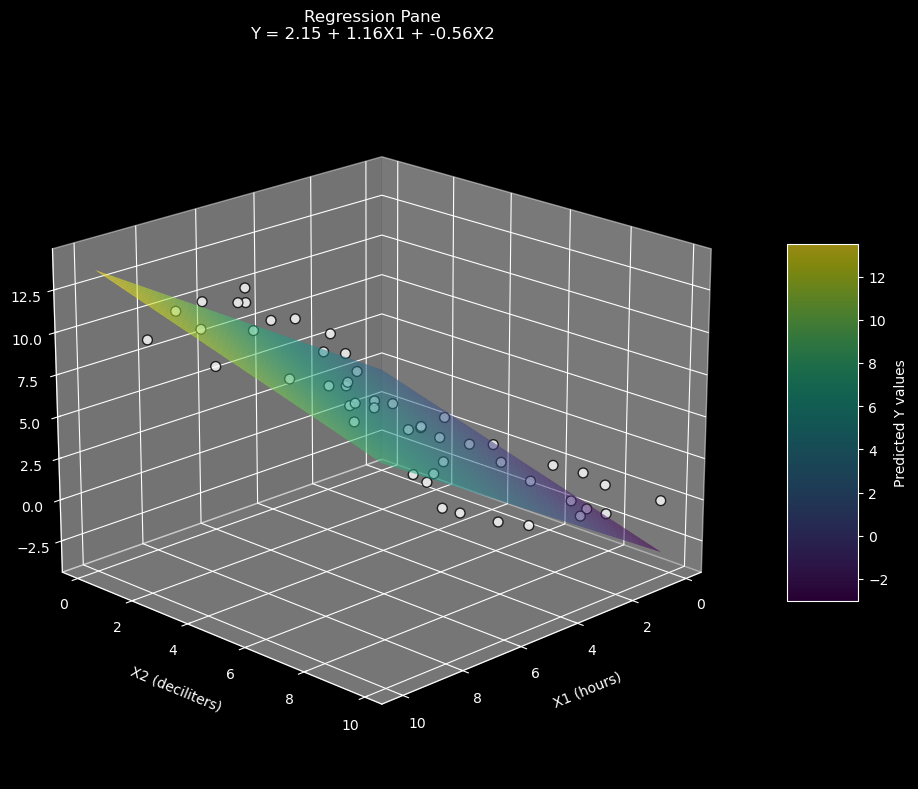

In [65]:
def plot_regression(df, beta_hat):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x1_range = np.linspace(df['X1'].min(), df['X1'].max(), 50)
    x2_range = np.linspace(df['X2'].min(), df['X2'].max(), 50)
    X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)
    Y_mesh = beta_hat[0] + beta_hat[1] * X1_mesh + beta_hat[2] * X2_mesh
    surf = ax.plot_surface(X1_mesh, X2_mesh, Y_mesh,
                          cmap='viridis',
                          alpha=0.6,
                          linewidth=0,
                          antialiased=True)

    scatter = ax.scatter(df['X1'], df['X2'], df['Y'],
                        c='white',
                        edgecolor='black',
                        s=50,
                        alpha=0.8,
                        label='Data Points')

    ax.set_xlabel('X1 (hours)', labelpad=10)
    ax.set_ylabel('X2 (deciliters)', labelpad=10)
    ax.set_zlabel('Y (minutes)', labelpad=10)
    title = f'Regression Pane\n'
    equation = f'Y = {beta_hat[0]:.2f} + {beta_hat[1]:.2f}X1 + {beta_hat[2]:.2f}X2'
    ax.set_title(title + equation, pad=20)
    # angle!
    ax.view_init(elev=20, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Predicted Y values')
    ax.grid(True, alpha=0.2, linestyle='--')
    plt.tight_layout()
    return fig

fig = plot_regression(df, beta_hat)
plt.show()

Mivel két magyarázó változónk van így egyenes helyett itt egy síkot illesztünk az adatpontjainkra, és a síktól mért távolsága a kék pontoknak mutatja mennyire teljesít jól a modellünk/mennyire olyan adatunk van amit lehet modellezni lineáris regresszióval. Jól látható a diagramon, hogy amikor X1 és X2 zérus akkor Y-ra 2.15-öt jósolunk.

## 2.1.4 Előrejelzési intervallum

Ahogyan a 2.1.2-es feladatnál:

$X_1$ = 5 h

$X_2$ = 1.5 dl

In [66]:
x_new = np.array([1, 5, 1.5])
Y_pred = x_new @ beta_hat
se_pred = np.sqrt(MSE * (1 + x_new @ XtX_inv @ x_new.T))
pi_lower = Y_pred - t_value * se_pred
pi_upper = Y_pred + t_value * se_pred

print(f"Predicted Y = {Y_pred:.2f} [min]")
print(f"95% Prediction Interval: [{pi_lower:.2f}, {pi_upper:.2f}] [min]")

Predicted Y = 7.13 [min]
95% Prediction Interval: [3.97, 10.29] [min]


Ugyanazt prediktáljuk mint előbb csak most ki kell hozzá számolni az intervallum két szélét, ahogy az előbbi feladatnál.

# 2.2 Illeszkedésdiagnosztika

## 2.2.1 Determinációs együttható ($R^2$) és korrigált $R^2$

$R^2 = 1 - \frac{\text{SSE}}{\text{SST}} = 1 - \frac{\sum (Y_i - \hat{Y}_i)^2}{\sum (Y_i - \bar{Y})^2}$

$R^2_{\text{adj}} = 1 - \frac{\text{SSE} / (n - k - 1)}{\text{SST} / (n - 1)} = 1 - (1 - R^2) \cdot \frac{n - 1}{n - k - 1}$

ahol:

SSE a teljes szórásnégyzetösszeg, ami méri a teljes varianciát az eredményváltozó (y) körül

SST a hiba szórásnégyzetösszeg, az eltérés a tényleges és az előrejelzett értékek között

Az $R^2$ megmutatja hogy a modell mennyire képes magyarázni az eredményváltozó varianciáját. 0 és 1 között mozog, minél magasabb az értéke annál jobb illeszkedést jelent. Ha $R^2$ kicsi az azt jelentheti hogy a magyarázó változók nem nyújtanak elegendő információt a célváltozóról. Mivel a sima $R^2$ mindig növekedni fog, ahogy új változókat adunk a modellünkhoz, még akkor is ha azok nem adnak extra információt, ezért hasznos a korrigált $R^2$ ami figyelembe veszi a modell változóinak számát is. Így az $R^2$ csökkenni is tud ha olyan változót adunk a modellünkhöz, ami nem járul hozzá a modellhez, így véd minket a túlilleszkedés ellen.

In [67]:
# just a quick redefine to be sure
X = np.column_stack((np.ones(len(df)), df['X1'], df['X2']))
Y_pred = X @ beta_hat
# calc
SST = np.sum((Y - np.mean(Y))**2)
SSR = np.sum((Y_pred - np.mean(Y))**2)
R_squared = SSR / SST
adj_R_squared = 1 - (1 - R_squared) * (n - 1) / (n - 3)
print("R-squared:", R_squared)
print("Adjusted R-squared:", adj_R_squared)

R-squared: 0.8724887962304763
Adjusted R-squared: 0.8670627875594327


$R^2$=87.25% ez egy egész korrekt érték, ami azt jelenti hogy a modellünk Y varianciájának csak 12.75%-át nem magyarázza. Korrigált $R^2$=86.71% csak 0.54%-al kisebb mint $R^2$ ami jelzi hogy mindkét magyarázó változónk nagyban segít a predikcióban.

# 2.3 Modelldiagnosztika

## 2.3.1 Modelldiagnosztikai tesztek

A modell tesztelése fontos, mivel meg kell győződnünk a becsült paraméterek és az egyes magyarázó változók valódi hozzájárulásáról. Először az egész modellt kell tesztelnünk, mivel az segít meghatározni hogy az összes magyarázó változó együttesen mennyire járul hozzá a függő változó varianciájának magyarázatához.

$H_0$: $b_0$ = $b_1$ = ... = $b_k$ = 0 azaz nincs magyarázóerő

$H_1$: ∃i: $b_i$ != 0 azaz legalább az egyik magyarázó változó szignifikáns

α = 0.05

A teljes modell relevanciáját F-próbával teszteljük.

$F = \frac{\text{SSR} / k}{\text{SSE} / (n - k - 1)}$

ahol:

k a magyarázó változók száma

n a minta elemszáma

SSR a magyarázott szórásnégyzetösszeg

SSE a hiba szórásnégyzetösszeg

és:

$\text{SSR} = \sum (\hat{Y}_i - \bar{Y})^2$

$\text{SSE} = \sum (Y_i - \hat{Y}_i)^2$

In [68]:
def f_test_for_full_model(Y, Y_pred, k=2):
    n = len(Y)
    Y_mean = np.mean(Y)
    SSR = np.sum((Y_pred - Y_mean)**2)
    SSE = np.sum((Y - Y_pred)**2)
    # number of predictors
    df_reg = k
    # residual degrees of freedom
    df_res = n - k - 1
    # we can do it like this too
    MSR = SSR/df_reg
    MSE = SSE/df_res

    F = MSR/MSE

    # critical F value
    F_crit = stats.f.ppf(0.95, df_reg, df_res)
    # p-value
    p_value = 1 - stats.f.cdf(F, df_reg, df_res)

    print(f"F-statistic: {F:.4f}")
    print(f"Critical F-value: {F_crit:.4f}")
    print(f"p-value: {p_value:.20f}")
    print(f"Degrees of freedom: {df_reg}, {df_res}")

f_test_for_full_model(df['Y'], Y_pred)

F-statistic: 160.7975
Critical F-value: 3.1951
p-value: 0.00000000000000011102
Degrees of freedom: 2, 47


Mivel F=160.7 > F_critical=3.195 elutasítjuk $H_0$-át. A p-value=0.0000 is > mint 0.05 ez alapján is elutasítjuk a nullhipotézist. Tehát a modellünk statisztikailag szignifikáns és közel 0% az esélye hogy csak véletlenül kapnánk ilyen jó eredményeket.

## 2.3.2 Változók szignifikanciájának tesztelése

Mivel a teljes modellünk szignifikáns most vizsgáljuk meg az egyes magyarázó váltózókat külön-külön. Az adott változó releváns ha a hozzá tartozó regressziós együtthatója szignifikánsan eltér a nullától. Az előbbi segít feltárni mely változók segítenek valójában a modellnek, és vannak-e olyanok amelyek csak zajt visznek be.

Minden egyes változóra (X1 & X2) külön megcsináljuk:

$H_0$: $b_i$ = 0 nincs hatása

$H_1$: $b_i$ != 0 jelentős hatással bír

α = 0.05

Az egyes együtthatók relevanciáját t-próbával teszteljük.

$t = \frac{\hat{\beta}_i}{SE(\hat{\beta}_i)}$

ahol:

$SE(\hat{\beta}_i) = \sqrt{\text{MSE} \cdot \text{(diagonal of } (X'X)^{-1})}$

In [69]:
def test_coefficients(X, Y, beta_hat, alpha=0.05):
    n = len(Y)
    # number of predictors (minus intercept)
    k = X.shape[1] - 1
    # residuals and MSE
    Y_pred = X @ beta_hat
    residuals = Y - Y_pred
    MSE = np.sum(residuals**2) / (n - k - 1)
    # standard errors
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(MSE * np.diag(XtX_inv))

    # t-statistics
    t_stats = beta_hat / se
    # critical value
    t_crit = stats.t.ppf(1 - alpha/2, n - k - 1)
    # p-values
    p_values = 2 * (1 - stats.t.cdf(abs(t_stats), n - k - 1))

    print("Coefficient Tests:")
    print(f"t_crit: {t_crit:.4f}")
    names = ["β₀ (Intercept)", "β₁ (X1)", "β₂ (X2)"]
    for i in range(len(beta_hat)):
        print(f"\n{names[i]}:")
        print(f"Estimate: {beta_hat[i]:.4f}")
        print(f"Std. Error: {se[i]:.4f}")
        print(f"t-statistic: {t_stats[i]:.4f}")
        print(f"p-value: {p_values[i]:.4f}")
        print(f"Significant at 5%: {abs(t_stats[i]) > t_crit}")

X = np.column_stack((np.ones(len(df)), df['X1'], df['X2']))
test_coefficients(X, df['Y'].values, beta_hat)

Coefficient Tests:
t_crit: 2.0117

β₀ (Intercept):
Estimate: 2.1534
Std. Error: 0.5459
t-statistic: 3.9445
p-value: 0.0003
Significant at 5%: True

β₁ (X1):
Estimate: 1.1619
Std. Error: 0.0760
t-statistic: 15.2937
p-value: 0.0000
Significant at 5%: True

β₂ (X2):
Estimate: -0.5580
Std. Error: 0.0746
t-statistic: -7.4767
p-value: 0.0000
Significant at 5%: True


Mivel mindegyik t érték abszolúértéke nagyobb mint t_kritikus (2.0117) ezért mindenhol elutasítjuk $H_0$-át, így mindegyik együtthatónk szignifikáns a vizsgált szignifikanciaszinten. Azt is látjuk hogy β₁ a legszignifikánsabb mivel neki van a legtávolabb a t értéke t kritikustól, illetve minél nagyobb a t érték annál kisebb a p érték, és annál erősebb bizonyítékunk van $H_0$-al szemben.

## 2.3.3 Multikollinearitás vizsgálata

A multikollinearitás a magyarázóváltozók közötti erős lineáris kapcsolatot jelenti, ami problémás lehet a többszörös lineáris regresszióban, mivel a becslések instabillá válhatnak. Ez a következőket jelenti:

A becslések instabilitása:
- Ha X₁ és X₂ erősen korrelálnak, nehéz szétválasztani az egyedi hatásukat Y-ra
- Kis változások az adatokban nagy változásokat okozhatnak a becsült együtthatókban
- A standard hibák megnövekednek, ami szélesebb konfidencia intervallumokat eredményez

Statisztikai következmények:
- A t-tesztek ereje csökken (nehezebb szignifikáns hatást kimutatni)
- Az együtthatók előjele váratlanul megváltozhat
- A paraméterek becslése pontatlanabbá válik

Gyakorlati problémák:
- Nehéz meghatározni, hogy melyik változó fontosabb a modellben
- A modell túlérzékennyé válik az adatokban lévő kis változásokra
- Az eredmények interpretálása félrevezető lehet


A multikollinearitás egyik mérőszáma a VIF (Variance Inflation Factor), és a következőképpen alakulhat az értéke:

VIF = 1: Nincs korreláció

1 < VIF < 5: Elfogadható korreláció

VIF ≥ 5: Jelentős multikollinearitás

In [70]:
def calculate_vif(df):
    # correlation coefficient between X1 and X2
    r = np.corrcoef(df['X1'], df['X2'])[0,1]
    # R²
    R2 = r**2
    VIF = 1 / (1 - R2)
    print("VIF Results:")
    print(f"VIF for both predictors: {VIF:.4f}")

    return VIF

VIF = calculate_vif(df)

VIF Results:
VIF for both predictors: 1.0144


Mivel a VIF értékünk nagyon közel van 1-hez, így nem áll fent szignifikáns multikollinearitás a magyarázó változóink között.

## 2.3.4 Hibatagok vizsgálata

In [71]:
def analyze_residuals(Y, Y_pred):
    residuals = Y - Y_pred
    # estimated variance (MSE)
    n = len(Y)
    k = 2
    df = n - k - 1
    variance = np.sum(residuals**2) / df
    # expected value (mean of residuals)
    mean_residuals = np.mean(residuals)
    print(f"Estimated variance (MSE): {variance:.4f}")
    print(f"Mean of residuals: {mean_residuals:.4f}")
    return residuals, variance

X = np.column_stack((np.ones(len(df)), df['X1'], df['X2']))
residuals, variance = analyze_residuals(df['Y'].values, Y_pred)

Estimated variance (MSE): 2.3611
Mean of residuals: 0.0000


Modell hibatagjának várható értéke:

$E(e) = \frac{1}{n} \sum e_i$

ahol $e_i = Y_i - \hat{Y}_i$

és a variancia becslése

$\sigma^2 = \frac{\sum e_i^2}{n - k - 1}$

A várható érték közel 0 ami jót jelent mivel a lineáris regresszióban ez egy alapkövetelmény pont ezt próbáljuk minimalizálni, és alapfeltétel.

A variancia értéke 2.3611 -> gyökvonás után Standard Error: 1.5366, ami azt jelenti hogy a modellünk predikciói átlagosan 1.54 egységben térnek el. 


Normality Test (Shapiro-Wilk):
Statistic: 0.9795
p-value: 0.5293
Normality assumption met at 5% level


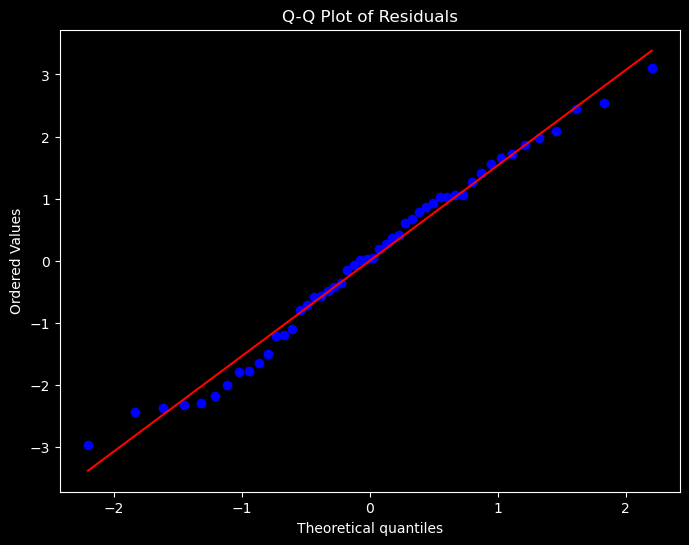

In [72]:
def test_normality(residuals):
    # Shapiro-Wilk test
    stat, p_value = stats.shapiro(residuals)
    print("\nNormality Test (Shapiro-Wilk):")
    print(f"Statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Normality assumption {'met' if p_value > 0.05 else 'violated'} at 5% level")

    # QQ plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.show()

test_normality(residuals)

H₀: A hibatagok normális eloszlást követnek
H₁: A hibatagok nem normális eloszlást követnek

ahol $W = \frac{\left(\sum a_i x_{(i)}\right)^2}{\sum (x_i - \bar{x})^2}$

$x_i$ rendezett hibatagok és $a_i$ konstansok az SW táblából

p-érték = 0.5293 > 0.05 -> így nem tudjuk elutasítani $H_0$-át, tehát a hibatagok normális eloszlst követnek az adott szignifikanciaszinten.

A Q-Q diagramon is jól látható hogy az adatpontjaink egész jól követik a főátlót.


In [73]:
def test_independence(residuals):
    # Durbin-Watson test
    d = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
    print("\nDurbin-Watson Test:")
    print(f"DW statistic: {d:.4f}")
    if d < 1.5:
        print("Positive autocorrelation might be present")
    elif d > 2.5:
        print("Negative autocorrelation might be present")
    else:
        print("No significant autocorrelation detected")

test_independence(residuals)


Durbin-Watson Test:
DW statistic: 2.1084
No significant autocorrelation detected


A Durbin-Watson teszt 0-tól 4-ig veszi fel az eredményhalmazát.

$DW = \frac{\sum (e_i - e_{i-1})^2}{\sum e_i^2}$

Eredmény értelmezése:
- DW ≈ 2: nincs korreláció
- DW < 1.5: lehetséges pozitív korreláció
- DW > 2.5: lehetséges negatív korreláció

Mi 2.1084-et kaptunk ami azt jelenti, hogy mindegyik megfigyelés független, nincs szisztematikus mintázat a hibákban, és a sorrendjük sem számít.

In [74]:
def test_homoscedasticity(X, residuals):
    # Breusch-Pagan test
    squared_residuals = residuals**2
    # regress squared residuals on X
    beta_bp = np.linalg.inv(X.T @ X) @ X.T @ squared_residuals
    squared_residuals_pred = X @ beta_bp
    # test statistic
    n = len(residuals)
    R2_bp = 1 - np.sum((squared_residuals - squared_residuals_pred)**2) / np.sum((squared_residuals - np.mean(squared_residuals))**2)
    bp_stat = n * R2_bp
    # compare with chi-square distribution
    # df = number of predictors
    p_value = 1 - stats.chi2.cdf(bp_stat, df=2)
    print("\nBreusch-Pagan Test:")
    print(f"Statistic: {bp_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Homoscedasticity assumption {'met' if p_value > 0.05 else 'violated'} at 5% level")

test_homoscedasticity(X, residuals)


Breusch-Pagan Test:
Statistic: 1.1619
p-value: 0.5594
Homoscedasticity assumption met at 5% level


$H_0$: homoszkedaszticitás (hibatagok varianciája konstans)
$H_1$: heteroszkedaszticitás (hibatagok varianciája NEM konstans)

Eredmények:

p = 0.5594 > 0.05 -> nem utasítjuk el $H_0$-át -> homoszkedaszticitás bebizonyítva, tehát a hibatagok varianciája konstans.


Megjegyzés:

A fentiek nagy részét kiszámolja -> statsmodels.regression.linear_model.OLS

-----------------------------------------------------------------------------------------------------

# 3. Feladat
## Idősoranalízis
Először beolvassuk a mintánkat:

In [75]:
with open('bead3.csv', 'r') as file:
    lines = file.readlines()[1:]
    data_list = [process_row(line.strip()) for line in lines]

df = pd.DataFrame(data_list, columns=['time','value'])
custom_stats(df)

------------------------HEAD------------------------
   time  value
0   1.0   1.16
1   2.0   2.53
2   3.0   1.73
3   4.0   1.18
4   5.0   2.47
------------------------SHAPE------------------------
(50, 2)
------------------------Stats------------------------
           time      value
count  50.00000  50.000000
mean   25.50000  11.839800
std    14.57738   8.783542
min     1.00000   1.160000
25%    13.25000   3.567500
50%    25.50000   9.675000
75%    37.75000  18.535000
max    50.00000  29.900000


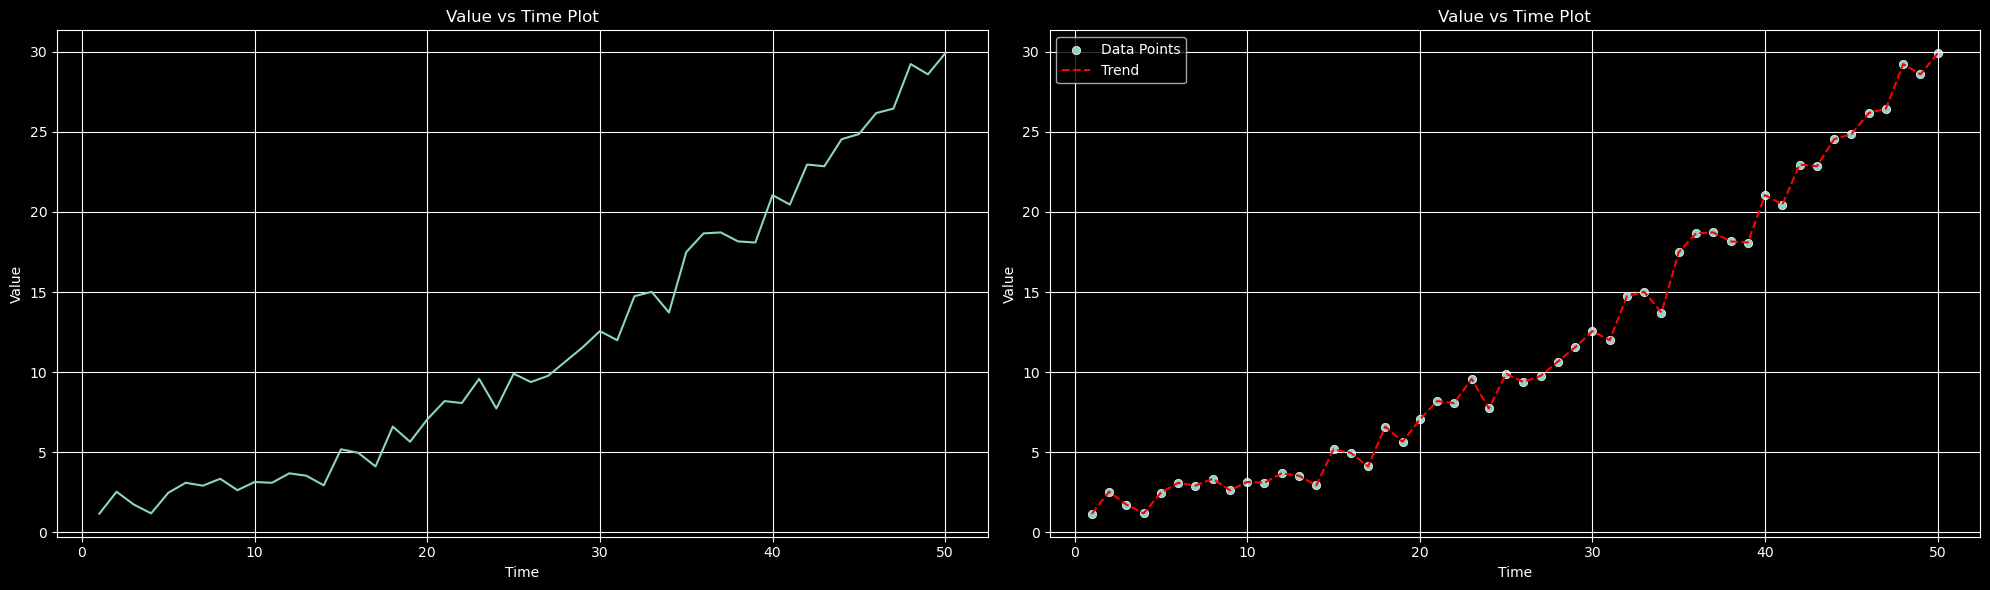

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(df['time'], df['value'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Value vs Time Plot')
ax1.grid(True)

sns.scatterplot(data=df, x='time', y='value', label='Data Points', ax=ax2)
ax2.plot(df['time'], df['value'], 'r--', label='Trend')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Value vs Time Plot')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [77]:
def perform_residual_analysis(X, y, model, y_pred):
    """
    Parameters:
    X: Feature variable (time)
    y: Target variable (value)
    model: Fitted model
    y_pred: Model predictions
    """
    residuals = y - y_pred
    standardized_residuals = residuals / np.std(residuals)

    fig = plt.figure(figsize=(20, 15))

    ax1 = fig.add_subplot(321)
    ax1.scatter(y_pred, residuals, color='blue', alpha=0.5)
    ax1.axhline(y=0, color='red', linestyle='--')
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Fitted Values')

    ax2 = fig.add_subplot(322)
    stats.probplot(standardized_residuals, dist="norm", plot=ax2)
    ax2.set_title('Normal Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 1. Normality Test (Shapiro-Wilk)
    _, shapiro_p = stats.shapiro(residuals)
    print(f"Shapiro-Wilk Test (Normality):")
    print(f"p-value: {shapiro_p:.4f}")
    print(f"Conclusion: Residuals are {'normally' if shapiro_p > 0.05 else 'not normally'} distributed")

    # 2. Durbin-Watson Test (Autocorrelation)
    dw_statistic = sm.stats.stattools.durbin_watson(residuals)
    print(f"\nDurbin-Watson Test (Autocorrelation):")
    print(f"Statistic: {dw_statistic:.4f}")
    print("Conclusion:", end=" ")
    if dw_statistic < 1.5:
        print("Positive autocorrelation detected")
    elif dw_statistic > 2.5:
        print("Negative autocorrelation detected")
    else:
        print("No significant autocorrelation")

    # 3. Breusch-Pagan Test (Heteroscedasticity) with OLS
    X_with_constant = sm.add_constant(X)
    ols_model = sm.OLS(residuals ** 2, X_with_constant)
    bp_results = ols_model.fit()
    bp_statistic = bp_results.fvalue
    bp_p_value = bp_results.f_pvalue

    print(f"\nBreusch-Pagan Test (Heteroscedasticity):")
    print(f"Statistic: {bp_statistic:.4f}")
    print(f"p-value: {bp_p_value:.4f}")
    print(f"Conclusion: Residuals have {'constant' if bp_p_value > 0.05 else 'non-constant'} variance")


# 3.1 Determinisztikus modell

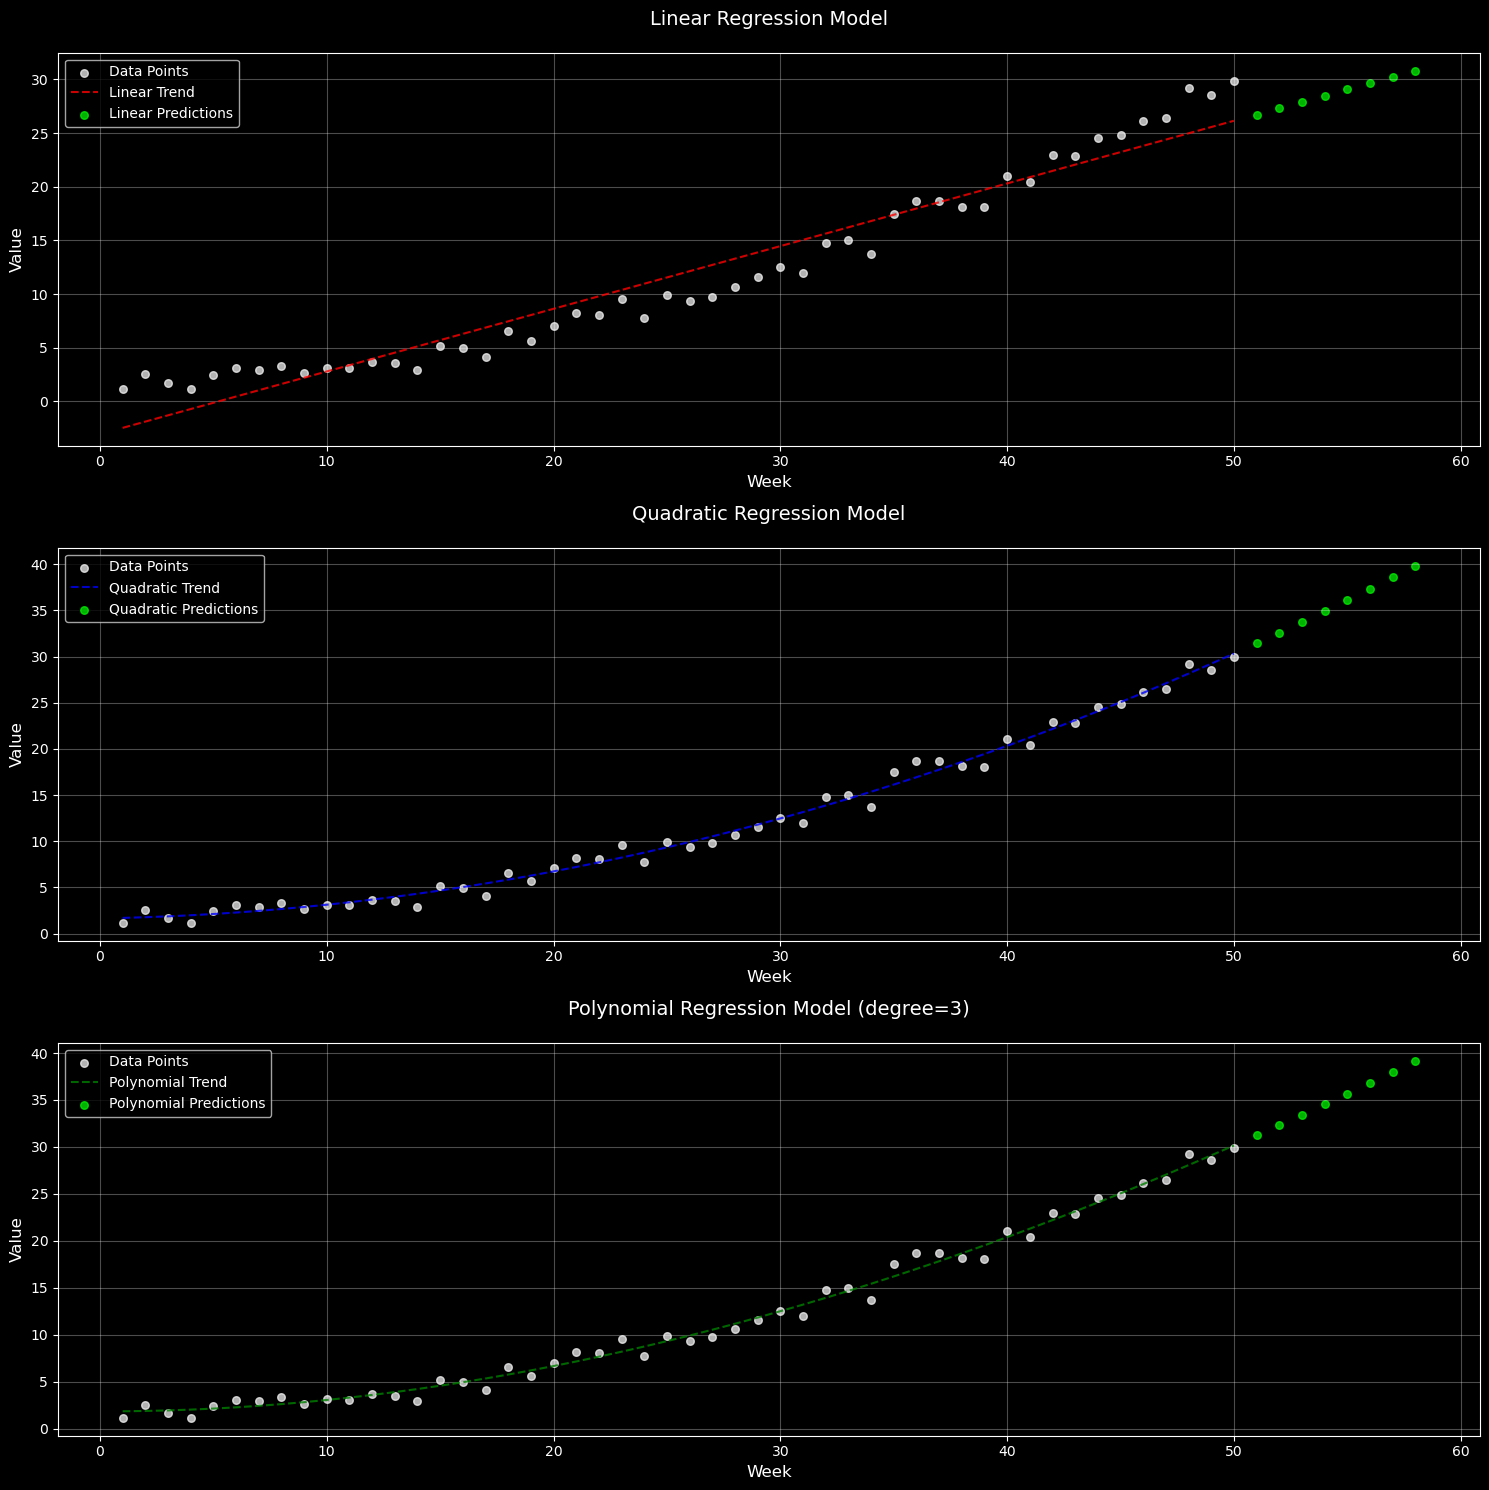


1. Linear Regression Results:
Intercept (b0): -3.0568
Slope (b1): 0.5842
R-squared: 0.9400
Mean of residuals: -0.0000
Standard deviation of residuals: 2.1304
Linear predictions: [26.73644082 27.32062281 27.9048048  28.48898679 29.07316879 29.65735078
 30.24153277 30.82571477]

2. Quadratic Regression Results:
Intercept (b0): 1.6451
Linear coefficient (b1): 0.0416
Quadratic coefficient (b2): 0.0106
R-squared: 0.9918
Mean of residuals: -0.0000
Standard deviation of residuals: 0.7854
Quadratic predictions: [31.4384102  32.57576507 33.73439581 34.91430243 36.11548493 37.33794331
 38.58167757 39.84668771]

3. Polynomial Regression Results:
R-squared: 0.9919
Mean of residuals: -0.0000
Standard deviation of residuals: 0.7823
Polynomial predictions: [31.22927373 32.31742001 33.42211057 34.54316687 35.68041036 36.83366247
 38.00274467 39.1874784 ]

Best performing model: Polynomial (R-squared: 0.9919)


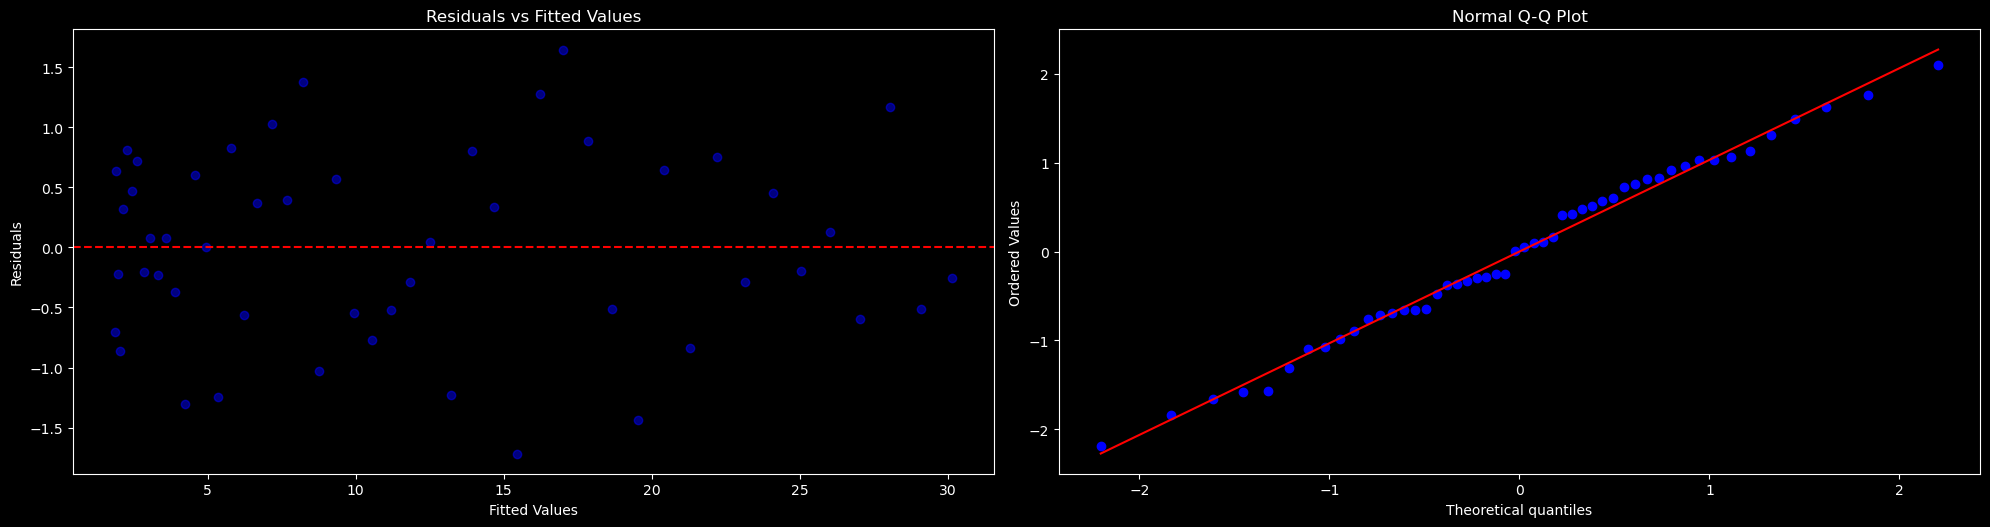

Shapiro-Wilk Test (Normality):
p-value: 0.8357
Conclusion: Residuals are normally distributed

Durbin-Watson Test (Autocorrelation):
Statistic: 2.3363
Conclusion: No significant autocorrelation

Breusch-Pagan Test (Heteroscedasticity):
Statistic: 1.1305
p-value: 0.2930
Conclusion: Residuals have constant variance


In [78]:
X = df['time'].values.reshape(-1, 1)
y = df['value'].values

# predictions for the next 8 values
last_week = X.max()
future_weeks = np.array(range(int(last_week) + 1, int(last_week) + 9)).reshape(-1, 1)

fig = plt.figure(figsize=(15, 15))

# 1. Linear Regression
ax1 = fig.add_subplot(311)
model_linear = LinearRegression()
model_linear.fit(X, y)
y_pred_linear = model_linear.predict(X)
r2_linear = r2_score(y, y_pred_linear)
future_predictions_linear = model_linear.predict(future_weeks)

ax1.scatter(X, y, color='white', alpha=0.7, label='Data Points', s=30)
ax1.plot(X, y_pred_linear, color='red', linestyle='--', label='Linear Trend', alpha=0.8)
ax1.scatter(future_weeks, future_predictions_linear, color='lime', alpha=0.7, label='Linear Predictions', s=30)
ax1.set_title('Linear Regression Model', fontsize=14, pad=20)
ax1.set_xlabel('Week', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Quadratic Regression
ax2 = fig.add_subplot(312)
X_quad = np.column_stack([X, X**2])
future_weeks_quad = np.column_stack([future_weeks, future_weeks**2])

model_quad = LinearRegression()
model_quad.fit(X_quad, y)
y_pred_quad = model_quad.predict(X_quad)
r2_quad = r2_score(y, y_pred_quad)
future_predictions_quad = model_quad.predict(future_weeks_quad)

ax2.scatter(X, y, color='white', alpha=0.7, label='Data Points', s=30)
ax2.plot(X, y_pred_quad, color='blue', linestyle='--', label='Quadratic Trend', alpha=0.8)
ax2.scatter(future_weeks, future_predictions_quad, color='lime', alpha=0.7, label='Quadratic Predictions', s=30)
ax2.set_title('Quadratic Regression Model', fontsize=14, pad=20)
ax2.set_xlabel('Week', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Polynomial Regression (degree=3)
ax3 = fig.add_subplot(313)
poly_model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)
r2_poly = r2_score(y, y_pred_poly)
future_predictions_poly = poly_model.predict(future_weeks)

ax3.scatter(X, y, color='white', alpha=0.7, label='Data Points', s=30)
ax3.plot(X, y_pred_poly, color='green', linestyle='--', label='Polynomial Trend', alpha=0.8)
ax3.scatter(future_weeks, future_predictions_poly, color='lime', alpha=0.7, label='Polynomial Predictions', s=30)
ax3.set_title('Polynomial Regression Model (degree=3)', fontsize=14, pad=20)
ax3.set_xlabel('Week', fontsize=12)
ax3.set_ylabel('Value', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n1. Linear Regression Results:")
print(f"Intercept (b0): {model_linear.intercept_:.4f}")
print(f"Slope (b1): {model_linear.coef_[0]:.4f}")
print(f"R-squared: {r2_linear:.4f}")
residuals_linear = y - y_pred_linear
print(f"Mean of residuals: {np.mean(residuals_linear):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals_linear):.4f}")
print(f"Linear predictions: {future_predictions_linear}")

print("\n2. Quadratic Regression Results:")
print(f"Intercept (b0): {model_quad.intercept_:.4f}")
print(f"Linear coefficient (b1): {model_quad.coef_[0]:.4f}")
print(f"Quadratic coefficient (b2): {model_quad.coef_[1]:.4f}")
print(f"R-squared: {r2_quad:.4f}")
residuals_quad = y - y_pred_quad
print(f"Mean of residuals: {np.mean(residuals_quad):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals_quad):.4f}")
print(f"Quadratic predictions: {future_predictions_quad}")

print("\n3. Polynomial Regression Results:")
poly_coefficients = poly_model.named_steps['linearregression'].coef_
print(f"R-squared: {r2_poly:.4f}")
residuals_poly = y - y_pred_poly
print(f"Mean of residuals: {np.mean(residuals_poly):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals_poly):.4f}")
print(f"Polynomial predictions: {future_predictions_poly}")

best_r2 = max(r2_linear, r2_quad, r2_poly)
if best_r2 == r2_linear:
    best_residuals = residuals_linear
    best_predictions = y_pred_linear
    best_model_name = "Linear"
elif best_r2 == r2_quad:
    best_residuals = residuals_quad
    best_predictions = y_pred_quad
    best_model_name = "Quadratic"
else:
    best_residuals = residuals_poly
    best_predictions = y_pred_poly
    best_model_name = "Polynomial"

print(f"\nBest performing model: {best_model_name} (R-squared: {best_r2:.4f})")
perform_residual_analysis(X, y, None, best_predictions)


3 modellt próbáltam ki: lineáris, kvadratikus, és polinomiális, majd az $R^2$ alapján a polinomiális bizonyult a legjobbnak 99%-os $R^2$-el.

Az együtthatók a következők: 
- b₀  :     1.8543
- 1   :     0.0000
- x   :    -0.0053
- x^2 :     0.0129
- x^3 :    -0.0000

y = b₀ + b₁x + b₂x² + b₃x³

Illetve a következő értékeket jósolta modellünk:

[31.22927373 32.31742001 33.42211057 34.54316687 35.68041036 36.83366247 38.00274467 39.1874784 ]

A Shapiro-Wilk teszt 0.8357 > 0.05 ami erős bizonyíték arra hogy a reziduumaink normális eloszlást követnek. (alap követelmény regresszióanalízisben)

A Durbin-Watson teszt 2.3363 ami a [0,4]-ig terjedő skálán azt jelenti hogy nincs jelentős autokorreláció. Ez azt jelenti hogy a modellünk hibája egy bizonyos időpontban nem befolyásolja a modellünk egy másik hibáját egy másik időpontban. - ez is alapkövetelmény

Breusch-Pagan teszt 0.2930 > 0.05 ami konstans varianciát jelent.

# 3.2 Exponenciális simítás

Model Parameters:
Smoothing Level (α): 0.2574
Smoothing Trend (β): 0.2574

Accuracy Metrics:
Root Mean Square Error (RMSE): 0.9719
Mean Absolute Error (MAE): 0.7943

Forecast for next 8 weeks:
Week 51: 30.89
Week 52: 31.87
Week 53: 32.85
Week 54: 33.84
Week 55: 34.82
Week 56: 35.80
Week 57: 36.78
Week 58: 37.76


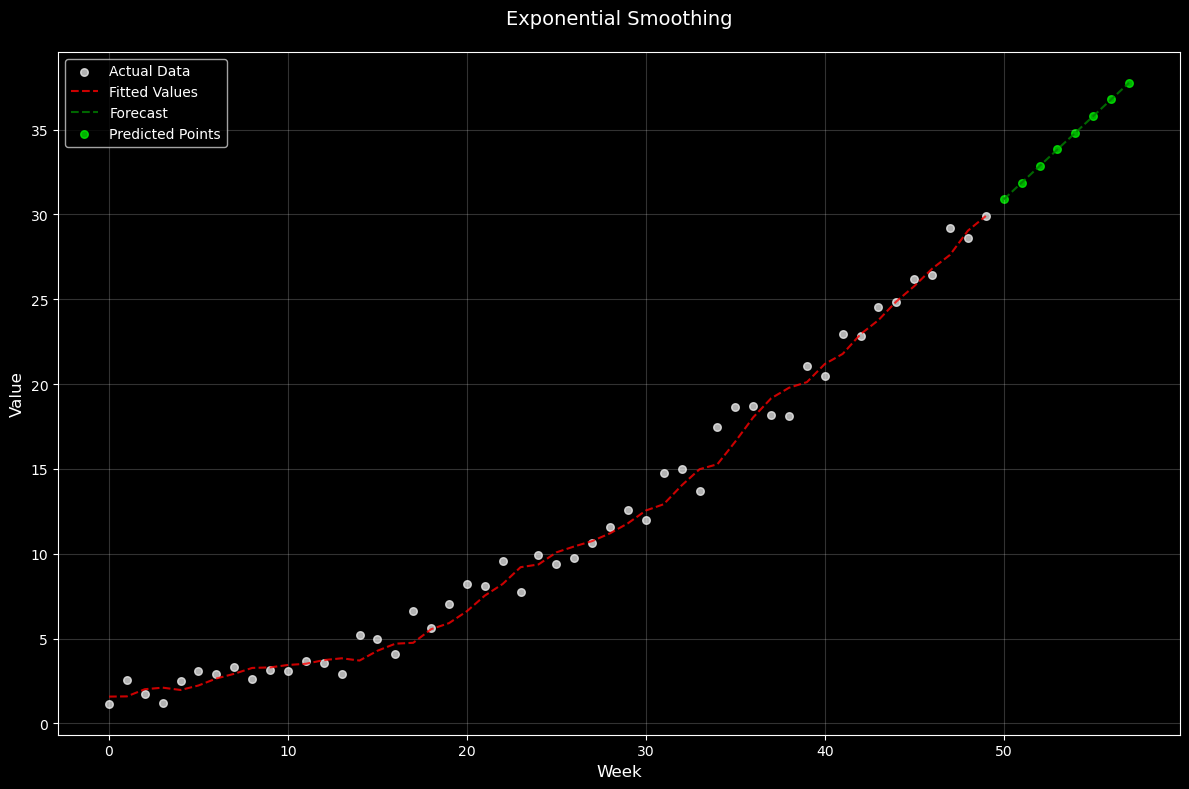

In [79]:
y = df['value'].values

# Holt's method (double exponential smoothing)
model = ExponentialSmoothing(y,
                           trend='add',                     # additive trend
                           seasonal=None,                   # no seasonality
                           initialization_method='estimated')
fitted_model = model.fit(optimized=True)
fitted_values = fitted_model.fittedvalues
forecast = fitted_model.forecast(8)

# accuracy metrics
mse = np.mean((y - fitted_values)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y - fitted_values))

plt.figure(figsize=(12, 8))
plt.scatter(range(len(y)), y, color='white', alpha=0.7, label='Actual Data', s=30)
plt.plot(range(len(y)), fitted_values, 'r--', label='Fitted Values', alpha=0.8)
forecast_index = range(len(y), len(y) + 8)
plt.plot(forecast_index, forecast, 'g--', label='Forecast', alpha=0.8)
plt.scatter(forecast_index, forecast, color='lime', alpha=0.7, s=30, label='Predicted Points')
plt.grid(True, color='white', alpha=0.2)
plt.title('Exponential Smoothing', fontsize=14, pad=20)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()

print("Model Parameters:")
print(f"Smoothing Level (α): {fitted_model.params['smoothing_level']:.4f}")
print(f"Smoothing Trend (β): {fitted_model.params['smoothing_trend']:.4f}")
print("\nAccuracy Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

print("\nForecast for next 8 weeks:")
for week, value in zip(range(len(y), len(y) + 8), forecast):
    print(f"Week {week + 1}: {value:.2f}")

plt.tight_layout()
plt.show()

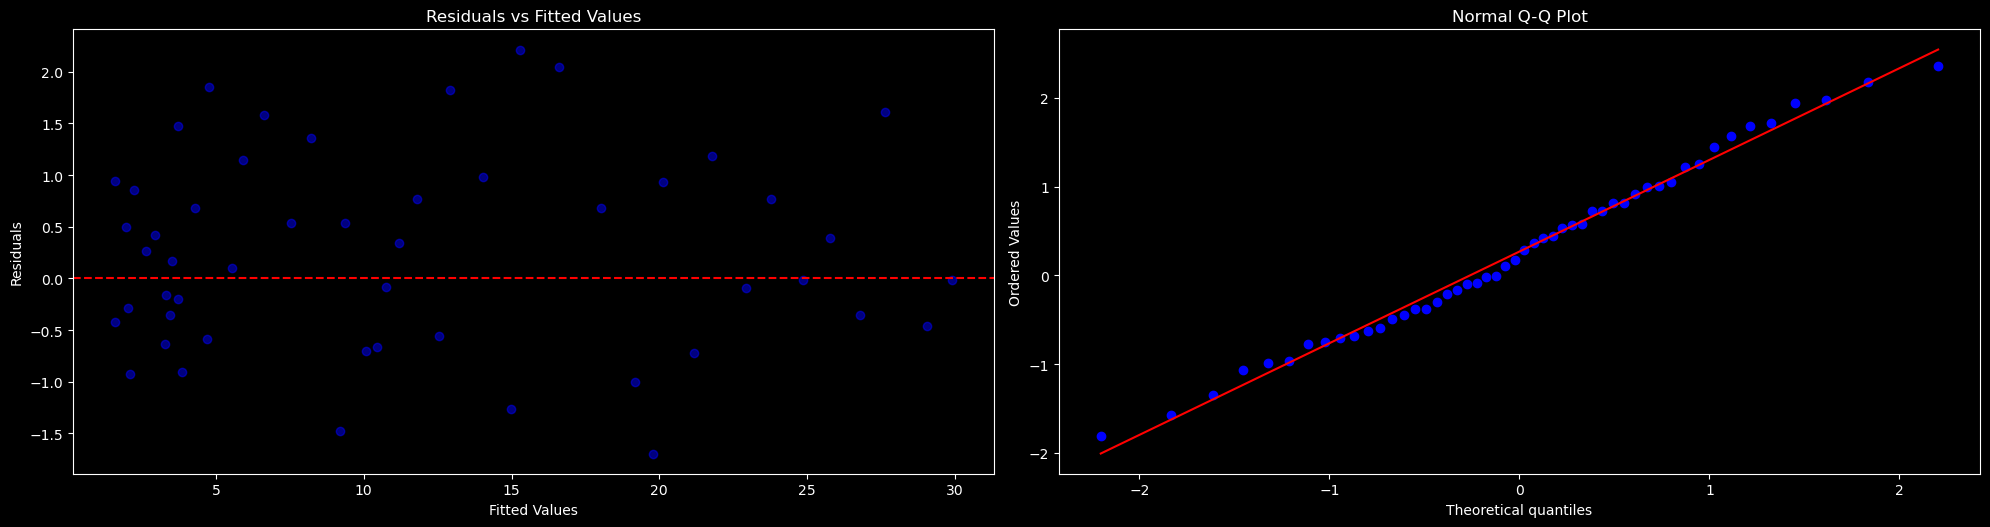

Shapiro-Wilk Test (Normality):
p-value: 0.8075
Conclusion: Residuals are normally distributed

Durbin-Watson Test (Autocorrelation):
Statistic: 2.0883
Conclusion: No significant autocorrelation

Breusch-Pagan Test (Heteroscedasticity):
Statistic: 1.5180
p-value: 0.2239
Conclusion: Residuals have constant variance


In [80]:
X = np.arange(len(y)).reshape(-1, 1)
perform_residual_analysis(X, y, None, fitted_values)


Itt is normális eloszlást követnek a reziduumaink (0.8075-ös p érték), nincs autokorreláció (2.0883-as Durbin-Watson teszt), illetve konstans variancia (Breusch-Pagan teszt 0.2239-es p érték).

# 3.3 ARIMA / SARIMA


Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5827      0.316      1.845      0.065      -0.036       1.202
ar.L1          0.0429      0.310      0.138      0.890      -0.564       0.650
ar.L2          0.1961      0.186      1.055      0.292      -0.168       0.560
ar.L3          0.2538      0.160      1.590      0.112      -0.059       0.567
ar.L4          0.1674      0.180      0.928      0.354      -0.186       0.521
ar.L5          0.2130      0.224      0.951      0.342      -0.226       0.652
ma.L1         -0.7137      0.281     -2.536      0.011      -1.265      -0.162
sigma2         0.9655      0.254      3.806      0.000       0.468       1.463

Accuracy Metrics:
Root Mean Square Error (RMSE): 0.9935
Mean Absolute Error (MAE): 0.8114

Forecast for next 8 weeks:
Week 51: 30.88 [28.95, 32.81]
Week 52: 31.62 [29.59, 33.64]
Week 53: 32.73 

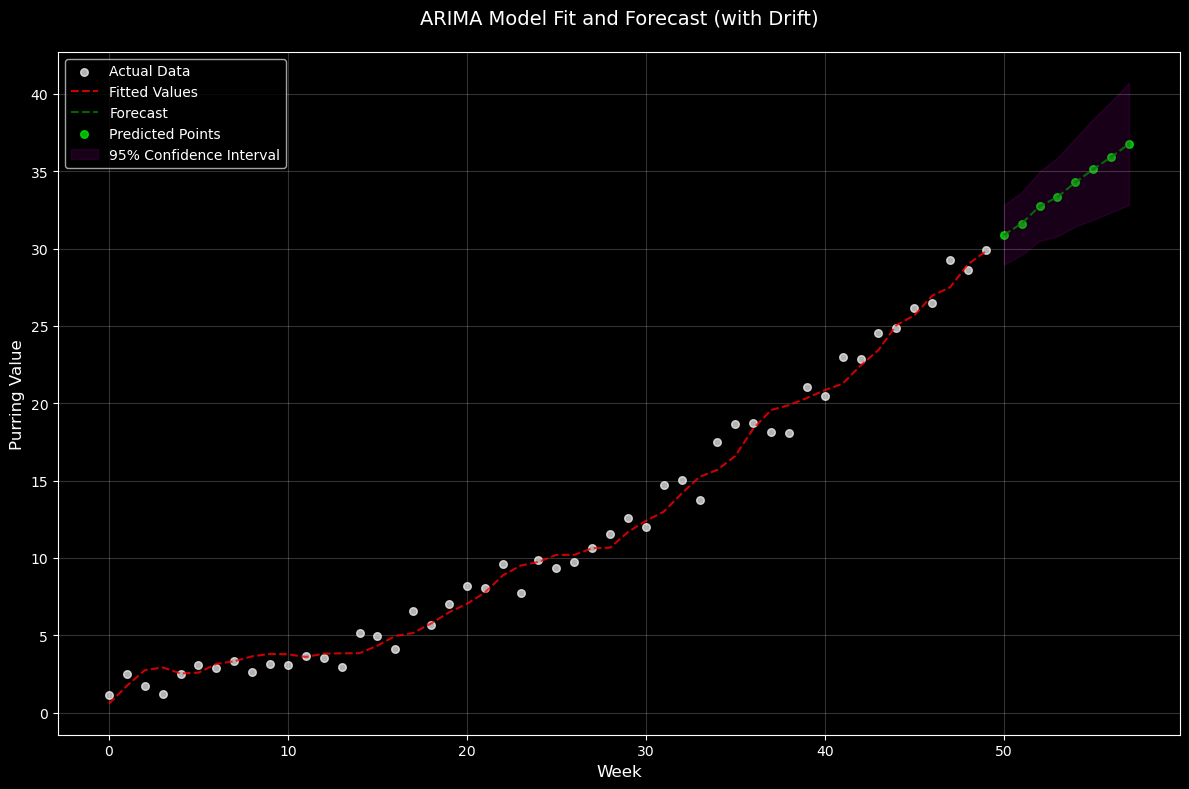

In [81]:
y = df['value'].values

model = ARIMA(y, order=(5,1,1), trend='t')
results = model.fit()

fitted_values = results.fittedvalues
forecast = results.forecast(steps=8)
forecast_ci = results.get_forecast(steps=8).conf_int()

plt.figure(figsize=(12, 8))
plt.style.use('dark_background')
plt.scatter(range(len(y)), y, color='white', alpha=0.7, label='Actual Data', s=30)
plt.plot(range(len(y)), fitted_values, 'r--', label='Fitted Values', alpha=0.8)
forecast_index = range(len(y), len(y) + 8)
plt.plot(forecast_index, forecast, 'g--', label='Forecast', alpha=0.8)
plt.scatter(forecast_index, forecast, color='lime', alpha=0.7, s=30, label='Predicted Points')
plt.fill_between(forecast_index,
                forecast_ci[:, 0],
                forecast_ci[:, 1],
                color='purple', alpha=0.2,
                label='95% Confidence Interval')
plt.grid(True, color='white', alpha=0.2)
plt.title('ARIMA Model Fit and Forecast (with Drift)', fontsize=14, pad=20)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Purring Value', fontsize=12)
plt.legend()

print("\nModel Summary:")
print(results.summary().tables[1])
residuals = y[1:] - fitted_values[1:]
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))

print("\nAccuracy Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

print("\nForecast for next 8 weeks:")
for i, (f, ci) in enumerate(zip(forecast, forecast_ci)):
    print(f"Week {len(y) + i + 1}: {f:.2f} [{ci[0]:.2f}, {ci[1]:.2f}]")

plt.tight_layout()
plt.show()

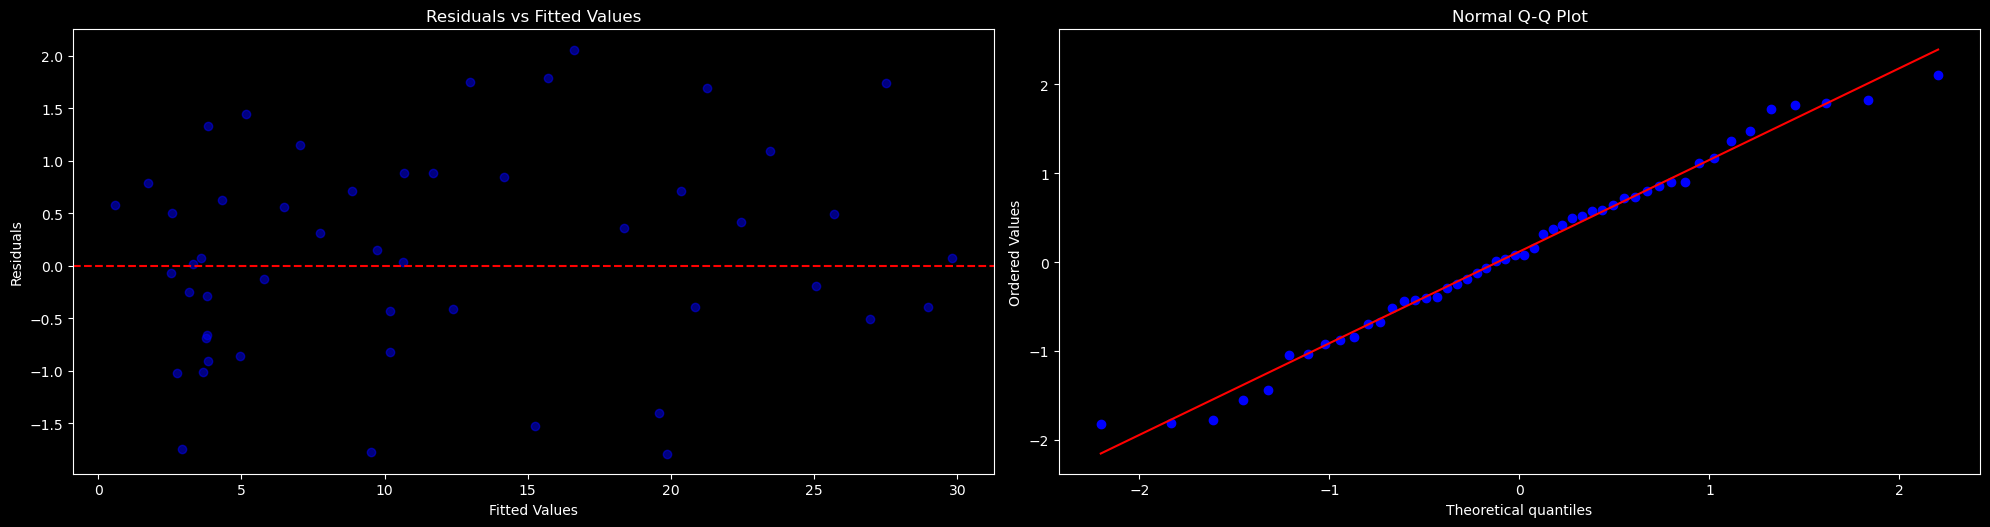

Shapiro-Wilk Test (Normality):
p-value: 0.5889
Conclusion: Residuals are normally distributed

Durbin-Watson Test (Autocorrelation):
Statistic: 1.9679
Conclusion: No significant autocorrelation

Breusch-Pagan Test (Heteroscedasticity):
Statistic: 1.5324
p-value: 0.2218
Conclusion: Residuals have constant variance


In [ ]:
X = np.arange(len(y)).reshape(-1, 1)
perform_residual_analysis(X, y, None, fitted_values)
